In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 安徽資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-安徽1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-安徽2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-安徽3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-安徽4.xls')
patent_df = pd.concat([df1,df2,df3,df4],ignore_index=True,sort=True)

In [3]:
patent_df.shape

(207972, 38)

In [4]:
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']

In [5]:
patent_df.shape

(207972, 38)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'34\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [12]:
patent_df_firm.shape

(9749, 38)

In [13]:
firm_gd.shape

(13270, 6)

In [14]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [15]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\安徽_廠商.xlsx')

# 非模糊比對

In [16]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(3213, 45)
(19806, 45)


In [17]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(5110, 50)
(12955, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [18]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\安徽_結果.xlsx')

# merge舊資料

In [5]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(1142, 44)
(14741, 44)
(2609, 49)
(14713, 49)


In [6]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\安徽_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', 'CPC', 'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）',
       '专利类型', '中国申请人区县', '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日',
       '发明人', '合享价值度', '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数',
       '文献页数', '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码',
       '申请人类型', '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)',
       '被引证次数', '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '合肥',
       '蚌埠', '蕪湖', '馬鞍山慈湖', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [7]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','合肥','蚌埠','蕪湖','馬鞍山慈湖','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(5987, 56)

In [8]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\安徽_結果.xlsx')

# 模糊比對

In [19]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(3454, 45)
(19477, 45)


In [20]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(5053, 50)
(12765, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\安徽_模糊結果.xlsx')

# 定位

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\安徽_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\安徽_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(5987, 56)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(14713, 56)
(366, 56)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\安徽_結果.xlsx')

# 作圖

In [8]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [9]:
patent_count.sort_values()

申请人2
(中外合资)合肥荣事达洗衣机有限公司       1
杜元君                      1
杜劲松                      1
杜卫国                      1
杜和兵                      1
                      ... 
安徽理工大学                2118
合肥工业大学                2308
中国科学技术大学              2416
安徽江淮汽车股份有限公司          3743
奇瑞汽车股份有限公司            5176
Name: 專利數, Length: 29140, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\安徽_結果.xlsx',index_col=0)
target1 = (31.84174,117.19985)
merge_df['合肥'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (32.90903,117.32002)
merge_df['蚌埠'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (31.27009,118.38663)
merge_df['蕪湖'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (31.74369,118.5146)
merge_df['馬鞍山慈湖'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\安徽_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (31.84174,117.19985)
target2 = (32.90903,117.32002)
target3 = (31.27009,118.38663)
target4 = (31.74369,118.5146)

for i in merge_df[merge_df['合肥']==''].index:
    merge_df.loc[i,'合肥'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'蚌埠'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'蕪湖'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'馬鞍山慈湖'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [11]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if (x['合肥']<10) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['蚌埠']<10)or(x['蕪湖']<10)or(x['馬鞍山慈湖']<10)) else 0,axis=1)

In [12]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\安徽_結果.xlsx')

In [13]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(14713, 56)
0.6466390267110719
0.008156052470604228


In [14]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       9514
1.0        495
2.0        350
3.0        251
4.0        221
5.0        198
6.0        318
7.0        295
8.0        266
9.0        249
10.0       218
11.0       163
12.0       148
13.0       154
14.0       122
15.0       122
16.0       128
17.0       108
18.0        75
19.0        86
20.0        79
21.0        68
22.0        62
23.0        66
24.0        53
25.0        53
26.0        29
27.0        32
28.0        38
29.0        34
30.0        33
31.0        27
32.0        38
33.0        29
34.0        19
35.0        21
36.0        19
37.0        17
38.0        26
39.0        12
40.0        19
41.0        11
42.0        17
43.0        18
44.0        10
45.0         9
46.0        15
47.0        19
48.0        11
49.0        11
50.0        14
51.0         2
52.0         4
53.0        11
54.0         6
55.0         6
56.0         7
57.0        13
58.0        10
59.0         7
60.0         8
61.0         7
62.0         6
63.0         6
64.0         8
65.0         7
66.0  

In [15]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     294
1.0       4
2.0       2
3.0       5
4.0       4
5.0       2
6.0       4
7.0       4
8.0       1
9.0       9
10.0      3
11.0      2
13.0      2
14.0      3
15.0      3
17.0      2
18.0      1
19.0      2
20.0      3
21.0      1
22.0      3
25.0      2
28.0      1
29.0      1
30.0      2
31.0      1
37.0      1
39.0      1
49.0      1
57.0      1
90.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

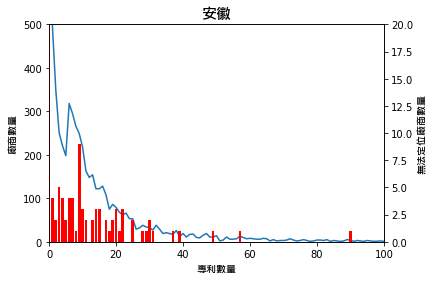

In [17]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('安徽',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,500])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\安徽_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1371
0.09625781085445483
29


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       241
2       142
3        83
4        89
5        65
6        57
7        58
8        52
9        47
10       35
11       29
12       38
13       37
14       29
15       24
16       29
17       24
18       14
19       19
20       12
21       12
22       11
23        9
24       17
25       13
26        7
27        4
28        8
29        7
30        8
31        2
32        5
33        6
34        6
35        5
36        1
37        4
38        4
39        3
40        5
41        2
42        6
43        6
44        4
45        4
46        2
47        2
48        1
49        1
50        4
53        6
54        1
55        2
56        2
57        3
58        1
59        3
60        2
62        2
63        1
64        2
65        1
67        1
69        1
70        1
72        1
73        2
76        2
77        1
78        1
80        2
82        1
83        1
85        1
86        1
87        1
88        1
89        2
93        1
96        1
97        1
102       1
103       1


In [4]:
not_merge[not_merge['專利數']>=1000].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,申请人地址,申请人省市代码,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,合肥,蚌埠,蕪湖,馬鞍山慈湖,早期園區,近期園區,專利數,name_clean
14434,,,,,,,,E04G21/00,CN102979305A; CN102979305B,2,0,发明授权,[雨山],[马鞍山],,CN,CN102979305B,2015-09-23 00:00:00,陈明宝; 刘祖国,9,CN,,23629,CN102635244A; CN1067231A; CN201661082U; JP2011000799A,"<text>王俊芳.高温环境下混凝土筒仓滑模温度控制技术研究与应用.《工业建筑》.2011, 第4卷(第S1期), 第1节第2段、第2.3.1节第4段、第2.3.3节第3段.</text>",...,安徽省马鞍山市雨山区雨山东路88号,安徽; 34,企业,CN201210539585.5,2012-12-14 00:00:00,CN102979305B; CN102979305A,2,,,0,到incoPat中查看\r\nCN102979305B,中国十七冶集团有限公司,中国十七冶集团有限公司,安徽省马鞍山市雨山区雨山东路88号,1,31.6732,118.533,127.711020,178.445185,46.814616,8.020783,0,1,1171,中国十七冶
14509,,,,,,,,F25D29/00,CN102997610B; CN102997610A,2,,发明授权,[肥东],[合肥],,CN,CN102997610B,2015-01-21 00:00:00,王振兴; 胡海宏; 孙超; 任伟,9,CN,,43176,CN1304023A; CN102589082A; CN101726073A; CN101963149A; JP2012102895A; JP07190509A,,...,安徽省合肥市长江西路669号,安徽; 34,企业,CN201210590023.3,2012-12-31 00:00:00,CN102997610A; CN102997610B,2,,,0,到incoPat中查看\r\nCN102997610B,合肥美的电冰箱有限公司,合肥美的电冰箱有限公司,安徽省合肥市长江西路669号,1,31.8478,117.208,0.991504,118.153937,128.980925,124.321310,1,0,1409,合肥美的电冰箱


Text(0.5, 0, '專利數量')

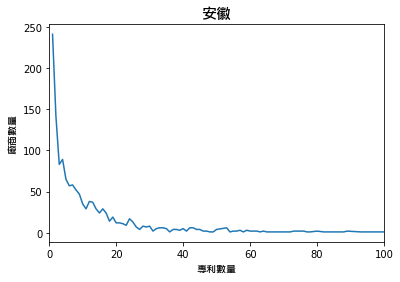

In [5]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('安徽',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [6]:
cleaned.to_excel(r'E:\paper\名稱merge\安徽_結果.xlsx')

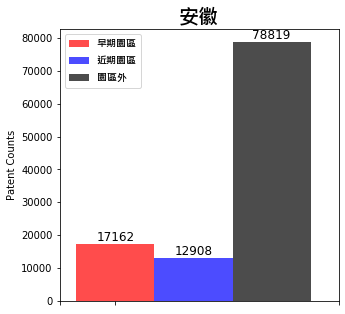

In [9]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum()+100, '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum()+100, '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()+100, '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('安徽',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

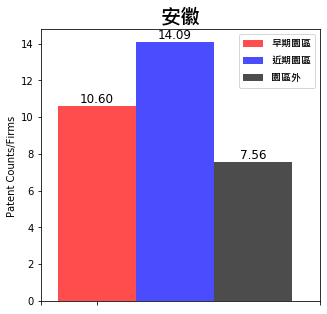

In [11]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.2f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('安徽',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)